In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#  Load full S&P 500 stock dataset
stocks = pd.read_csv('sp500_stocks.csv', parse_dates=['Date'])

# Filter for DIS (Disney)
dis = stocks[stocks['Symbol'] == 'DIS'].copy()

# Clean up: remove rows with missing Close prices
dis.dropna(subset=['Close'], inplace=True)

# Set datetime index and sort
dis.set_index('Date', inplace=True)
dis.sort_index(inplace=True)

# Preview
dis.head()


,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,DIS,27.593044,32.070000,32.750000,31.870001,32.50,13700400.0
2010-01-05,DIS,27.524214,31.990000,32.160000,31.700001,32.07,10307700.0
2010-01-06,DIS,27.377951,31.820000,32.000000,31.680000,31.90,10709500.0
2010-01-07,DIS,27.386553,31.830000,31.860001,31.540001,31.77,8202100.0
2010-01-08,DIS,27.429571,31.879999,31.940001,31.530001,31.66,7657500.0


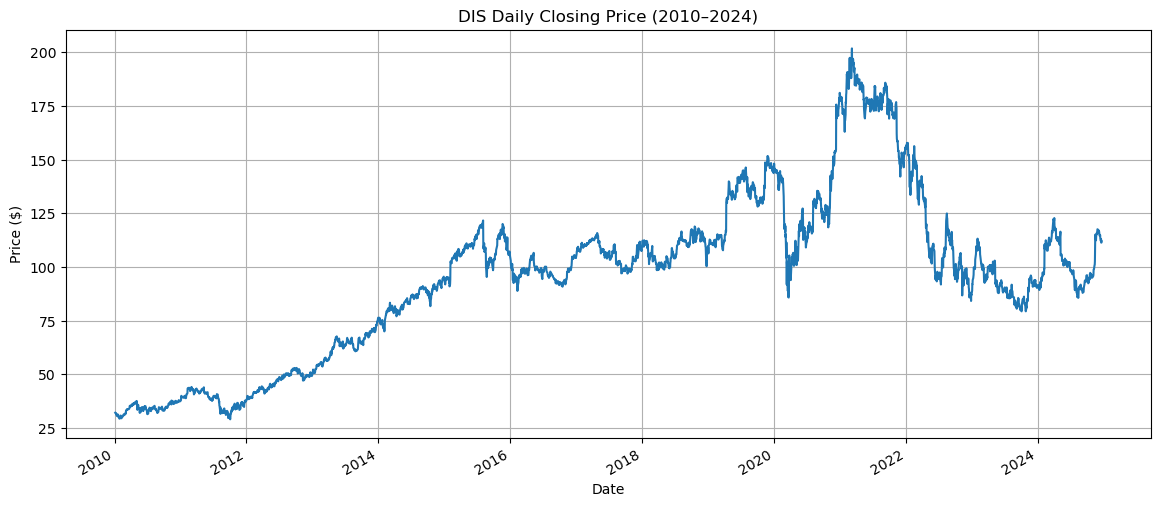

In [6]:
# Plot daily closing prices
plt.figure(figsize=(14, 6))
dis['Close'].plot(title='DIS Daily Closing Price (2010–2024)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the closing price
result = adfuller(dis['Close'])

# Output results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -1.9907353290725083
p-value: 0.290650050937896
Critical Value (1%): -3.4320982741938835
Critical Value (5%): -2.8623124910596176
Critical Value (10%): -2.567181207712407


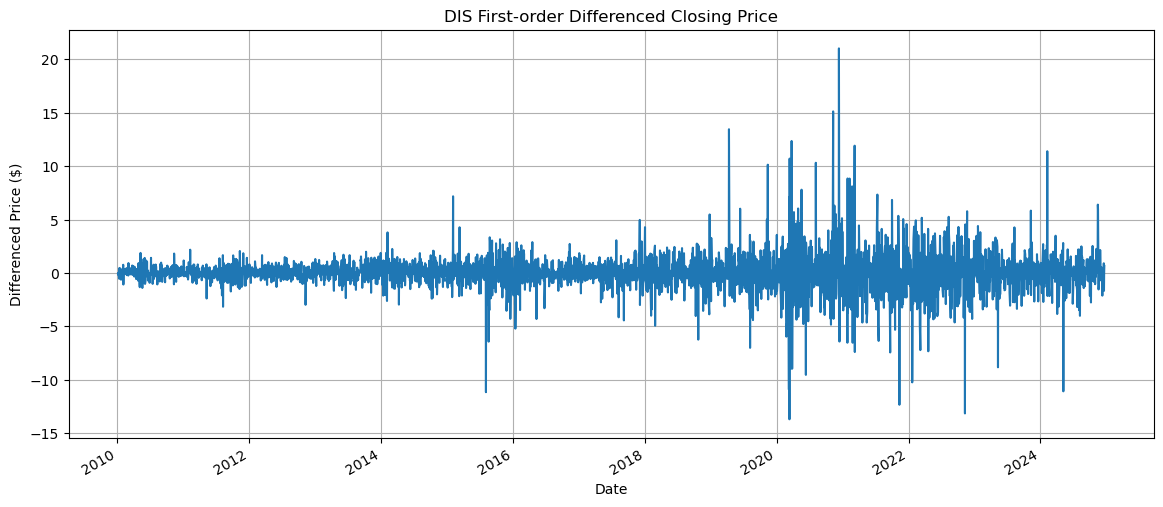

In [8]:
# First-order differencing
dis_diff = dis['Close'].diff().dropna()

# Plot differenced series
plt.figure(figsize=(14, 6))
dis_diff.plot(title='DIS First-order Differenced Closing Price')
plt.ylabel('Differenced Price ($)')
plt.grid(True)
plt.show()

In [9]:
# ADF test on differenced series
result_diff = adfuller(dis_diff)
print("ADF Statistic (1st diff):", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic (1st diff): -11.262680368167354
p-value: 1.607544915947484e-20
Critical Value (1%): -3.4321010830950787
Critical Value (5%): -2.862313731833426
Critical Value (10%): -2.5671818682559446


In [10]:
from pmdarima import auto_arima

# Fit auto_arima to original (non-differenced) series
stepwise_model = auto_arima(
    dis['Close'],
    seasonal=False,     # Try True later if you suspect weekly/monthly patterns
    d=1,                # We already know 1 differencing is needed
    trace=True,
    suppress_warnings=True,
    stepwise=True
)

# Display best model summary
stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14830.599, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14831.152, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14824.771, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14824.899, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14829.718, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14826.601, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14826.599, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14828.606, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14823.392, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14825.214, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14825.214, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14823.522, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14827.217, Time=0.27 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.410 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3768
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -7409.696
Date:                Sat, 19 Apr 2025   AIC                          14823.392
Time:                        00:08:36   BIC                          14835.861
Sample:                             0   HQIC                         14827.826
                               - 3768                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0470      0.009     -5.505      0.000      -0.064      -0.030
sigma2         2.9925      0.022    135.175      0.000       2.949       3.036
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47580.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              13.75   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model
model = SARIMAX(dis['Close'], order=(1, 1, 0))
results = model.fit()

# Show summary
results.summary()


c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3768
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -7409.696
Date:                Sat, 19 Apr 2025   AIC                          14823.392
Time:                        00:10:03   BIC                          14835.861
Sample:                             0   HQIC                         14827.826
                               - 3768                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0470      0.009     -5.505      0.000      -0.064      -0.030
sigma2         2.9925      0.022    135.175      0.000       2.949       3.036
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47580.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              13.75   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


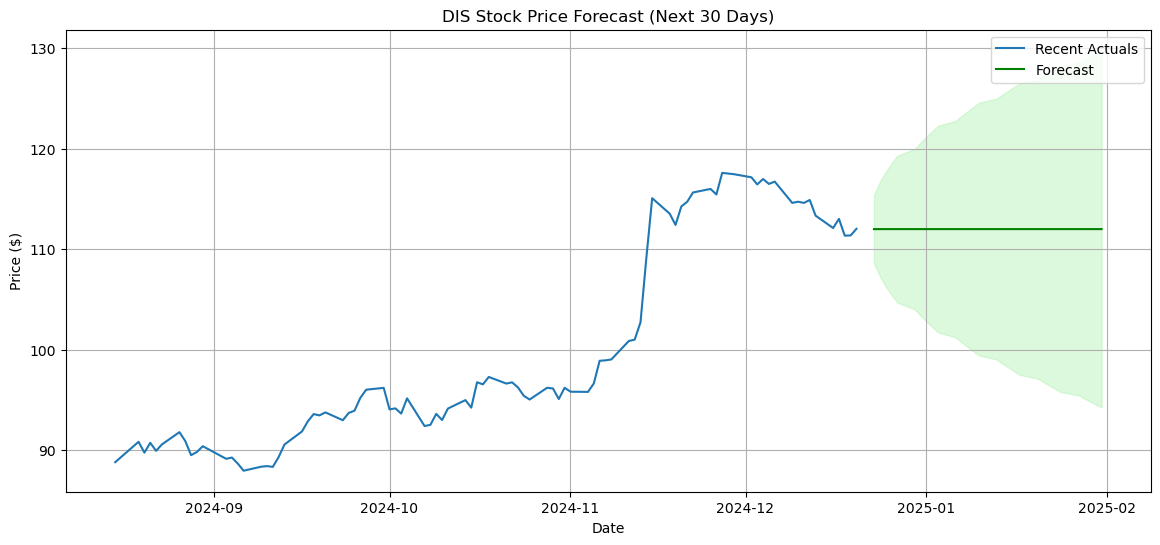

In [12]:
# Forecast 30 days ahead
n_steps = 30
forecast = results.get_forecast(steps=n_steps)

# Extract forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create forecast index starting from the last observed date
forecast_index = pd.date_range(start=dis.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')  # B = business days

# Plot
plt.figure(figsize=(14, 6))
plt.plot(dis.index[-90:], dis['Close'].iloc[-90:], label='Recent Actuals')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('DIS Stock Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()
